# The Game, is On!: The DQN Trilogy

#### First, I have to give the proper credit to ***Udacity*** for making their ***Reinforcement Learning Nanodegree*** files open source in github. I used many of their codes

Hello! In this blog , I am trying to work on ***Deep Q Network***, ***Double Deep Q Network*** and ***Duelling Double Deep Q Network***! 

### Index

- [Background](#background)
- [Bellman Update Equation](#bellman)
- [The Game](#game)
- [DQN](#dqn)
- [Base Q Network Class](#QNetwork)
- [Agent](#agent)
- [ReplayBuffer](#replaybuffer)
- [Learn Method](#dqn_learn)
- [Debugging RL](#debug)
- [Visualization function](#vis)
- [DQN learning process](#learning-process)
- [DQN with target network](#dqn_with_target)

### Prerequisites

To learn from this blog, some prerequisite knowledges are required

- Q learning. If you dont have intuition about Q learning , no problem. Look at this [prequel](https://sezan92.github.io/2020/03/18/QLearning.html)!
- Deep Learning basics


Lets start!!

<a id="background"></a>
### BackGround

Before starting full coding, let's get a background check

#### The problem of Q Learning

The biggest problem with Q-learning is that,it only takes discrete inputs and gives discrete values as outputs. In the Mountain Car problem, we solved this issue by discretizing states which are actually continuous. But this can't be done always. Specially when the states are multidimensional states or images. Deep learning comes here to solve this problem!

For example, breakout game by atari

![](Atari-breakout.jpg)

Here , the states are the actual image itself! It is 210x160x3 size RGB numpy array. How will you make discrete for $Q learning$ ? Will that be efficient ? ***NO***! . DQN comes us to save us!

So, we will replace the Q table explained in the last tutorial with a Neural Network. i.e. some thing like the following picture

![](Q2DQN.png)

***But there is one little problem!***

In our mountain car problem, we have three discrete actions. $0,1 & 2$ . Using the above architecture, we will have to calculate $Q$ value for each action . Because , you need to take the action with best $Q$ value. To get the action of the best $Q$ value, you need to know the $Q(state,action)$ for each state! So in our case, we will have to run same feed forward process three times!

What if we have more 100 actions ? Will we feed forward 100 times! It is a bit inefficient!! Instead, we will use the following architecture.

![](NewDQN.png)

Meaning, our output layer will calculate $Q$ value for each action. As a result we can calculate Q values in one single forward pass each step! And then we will choose the action with maximum value

<a id="bellman"></a>
#### Bellman Update Equation

In the Original Equation, the bellman update equation is 
\begin{equation}
Q(s_t,a) = Q(s_t,a) + \alpha (r+\gamma max_a(Q(s_{t+1},a))-Q(s_t,a_t))
\end{equation}

For DQN, we will use similar equation, using Gradient descent
\begin{equation}
\theta_Q \gets \theta_Q - \alpha \frac{\partial}{\partial \theta}(r+ \gamma max_a(Q_{\theta}(s_{t+1},a))-Q_{\theta}(s_t,a))^2
\end{equation}

Here $\theta$ means weights and $Q_{\theta}$ means QNetwork model with weights $\theta$

If you are intelligent enough, then you may ask , why there is a squared part in the gradient descent equation but not in the actual bellman update equation? The reason might be, Mean squared errors are more sensitive to sudden spikes in the target data, which makes it most popular metric for regression models!

#### The Concept of Experience Replay

One of the problems in Reinforcment learning is relearning Problem. That is , suppose, in the course of trial and error, one state $s_t$ comes only once or twice, and never comes back. What will happen? There is a chance that the Agent will forget that experience after some time- like us! . So we need to make the agent keep some kind of track of that memory as well. This problem was solved in 1993- yes 26 years ago- by Long Ji lin. In his paper, ***Reinforcement Learning for Robots Using Neural Networks*** , he introduced the concept of Experience Replay. What he did was, he initialized a buffer of a certain size . He stored the experiences of the agent, i.e. state $s_t$, action $a$,next state $s_{t+1}$, reward $r$ . Before training the agent, he you just sample randomly from the buffer . It also helps randomizing the data , which in turn, helps to converge the model faster, as mentioned by Yoshua Bengio in his paper ***Practical Recommendations for Gradient-Based Training of Deep
Architectures***,2012 

#### The concept of $\epsilon$-greedy Policy

In the beginning of training, we will have to explore random actions. Because we dont know the value of each action for each state. So we will take some random actions. We will evaluate those actions and see which random action gives us the most rewards. We will try to increase those actions. It means, at first you just ***explore*** different actions , the more you take actions the less you explore and more use your previouse experience to guide you-known as ***exploit***.  This thing can be done using a technique -with another freaking out name- $\epsilon$-greedy policy. 

The big idea is that, we will select a value of $\epsilon$ , suppose $0.9$. Then we will generate a random floating point number . If the generated number is greater than $\epsilon$ we will take action according to the DQN, otherwise a random action. After each episode , we will decrease the value of $\epsilon$ . As a result , in the last episodes, the agent will take actions according to DQN model, not the random actions.

- Set $\epsilon$
- Generate random number $n_{rand}$
- if $n_{rand} < \epsilon$ ***do***
- - take random action
- else ***do***
- - take action according to DQN

***Lets play the game!***

<a id="game"></a>
## The Game

For this blog I will be solving ***Lunarlander*** environment in ```open ai gym``` 

![](poster.jpg)

The goal is to land the ship in between the two flags properly.

From the gym open ai page, 
***Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.***

- 0 do nothing
- 1 fire left orientation engine
- 2 fire main engine
- 3 fire right orientation engine

<a id="package"></a>
### Importing packages

In [1]:
import gym
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
%matplotlib inline

Initiating gym environment

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/floyd/home/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


saving ```state_shape``` and ```actions_shape```

In [3]:
state_shape= env.observation_space.shape[0]
action_size= env.action_space.n

<a id="dqn"></a>
## DQN

<a id="QNetwork"></a>
### Q Network class 

Here , throughout the blog we will use same network named ```QNetwork``` . Well, not 100% . In duelling dqn we will make slight change! But thats for later! I am defining a model with 2 hidden layers, with relu activation. The final output is linear output same as action size

In [4]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=150, fc2_units=120):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.final = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.final(x)


<a id="agent"></a>
### Agent

Notice , I didnt define the methods ``` __init__ , step , act and learn ``` . I will define them later and add them to the same agent

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        pass
    
    def step(self, state, action, reward, next_state, done):
        pass
    def act(self, state, eps=0.):
        pass
    def learn(self):
        pass

<a id="replaybuffer"></a>
### Replaybuffer 

Let's first declare a class of Replaybuffer. I used ***Udacity RL*** ```ReplayBuffer``` class

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Let's make ```__init__``` method for the ```Agent``` class

In [7]:
def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.

    Params
    ======
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    # Q-Network
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    # Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0
    self.criterion=nn.MSELoss()

In [8]:
Agent.__init__=__init__

Now the ```act``` method. 

In [9]:
def act(self, state, eps=0.):
    """Returns actions for given state as per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
        action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

In [10]:
Agent.act=act

And the ```step``` method

In [11]:
def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

In [12]:
Agent.step=step

***The ``` __init__```,```act``` and ```step``` methods are exactly as Udacity RL nanodegrees github repository coded. I only changed in the ```learn``` method***

<a id="dqn_learn"></a>
The ```learn``` method

In [13]:
def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences


    "*** YOUR CODE HERE ***"
    ### My code starts###
    maxQ1=torch.max(self.qnetwork_local(next_states),0)[0]
    maxQ2=torch.max(self.qnetwork_local(next_states),1)[0]
    maxQ=maxQ2.reshape(-1,1)


    y=rewards+gamma*torch.max(maxQ,1)[0]*(1-dones)

    loss=F.mse_loss(y,self.qnetwork_local(states).gather(1,actions))
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    ### My code ends ####


    

In [14]:
Agent.learn=learn

So my input is basically from lines ```14-24```. And to be brutally honest , I will have to change mostly these lines for other algorithms as well!

### Wait a minute!

Before starting to training , we should devise a way to debug our learning process! i.e. , we have to make sure our model is really good at approximating values of each state-action pair! Obviously, one can say, by looking at the fool training process or the game itself! But not always games can be visulalized -like i am using cloud gpu where visualizing the game is difficult! We need a method by some kind of scores to get the intuition that our model is really worlking! but ***How to do that?***

So we have to know a little about expected reward return function!

#### Expected Return and Value functions

In summary, expected return is the sum of all future rewards, we denote it as $G_t$

\begin{equation}
G_t = R_{t+1}+R_{t+2}+R_{t+3}+.........R_T
\end{equation}
\begin{equation}
G_t = \sum\limits_{k=t+1}^{T} R_k
\end{equation}

But we will use, discount factor $\gamma$ , why? Because, for many games we might be more interested in immediate rewards than the reward 1000 steps after . Also there might be other factors after 100 timesteps like ***stock market*** ,which will lead us to focus more on immediate future rewards 

\begin{equation}
G_t = \gamma R_{t+1}+\gamma^2 R_{t+2}+\gamma^3 R_{t+3}+.........+\gamma^{T-1} R_T
\end{equation}
\begin{equation}
G_t = \sum\limits_{k=t+1}^{T} \gamma^{k-1} R_k
\end{equation}

Value functions $V$ of state $s$ is the expected return when at state $s$ following a certain policy $\pi$

\begin{equation}
V_\pi(s) = E[G_t|S_t=s]
\end{equation}

$Q$ function would be the expected return for a state $s$ and action $a$

\begin{equation}
Q(s,a) = E[G_t|S=s,A_t=a]
\end{equation}

SO, ***if our model gives higher $Q(s,a)$ value for the state-action pair where the Expected Return $G_t$ is higher, we can get the idea that our model is working!***

<a id="debug"></a>
### Debug

Lets start working on visualizing the Expected return and values

Lets make a dictionary to capture all the data of an episode

In [15]:
experience={"state":[],
           "action":[],
           "reward":[]}


Untrained Agent

In [16]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.01              # for soft update of target parameters
LR = 0.001               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [17]:
agent=Agent(state_size=state_shape,action_size=action_size,seed=0)

In [18]:
state = env.reset()

for j in range(200):
    experience["state"].append(state)
    action = agent.act(state)
    new_state, reward, done, _ = env.step(action)
    experience["action"].append(action)
    experience["reward"].append(reward)
    
    if done:
        break 
        
env.close()

Importing pandas for data analysis

In [19]:
oubleimport pandas as pd

Experience Dataframe

In [20]:
experience_df=pd.DataFrame(experience)

Discount factor

In [21]:
gamma=0.99

All the rewards

In [22]:
rewards=experience_df.reward.values.tolist()

Initializing Expected returns

In [23]:
Gt=[None]*len(rewards)

In [24]:
for i in range(len(rewards)):
    s=rewards[i]
    for j in range(1,len(rewards[i+1:])):
        s=s+(gamma**j)*rewards[j]
    Gt[i]=s
        

In [25]:
experience_df["Gt"]=Gt

All states of an episode

In [26]:
states= experience_df.state.values.tolist()

Values initializing

In [27]:
Vs = [None]*len(states)

Getting the Values. We are taking maximum value of each Q(s) array as our action will be based on maximum value

In [28]:
for i in range(len(states)):
    state_tensor=torch.from_numpy(states[i]).float().unsqueeze(0).to(device)
    Qsa= agent.qnetwork_local(state_tensor)
    Vs[i]=np.max(Qsa.cpu().detach().numpy())

In [29]:
experience_df["Value"]=Vs

Lets visualize the Expected return and Values using seaborn color map. 

In [30]:
import seaborn as sns
 
cm = sns.light_palette("red", as_cmap=True)
 
experience_df[["Gt","Value"]].style.background_gradient(cmap='viridis')

,Gt,Value
0,-277.919,0.185379
1,-286.907,0.185379
2,-298.154,0.185379
3,-351.918,0.185379
4,-352.746,0.185379
5,-348.546,0.185379
6,-342.416,0.185379
7,-336.186,0.185379
8,-330.087,0.185379
9,-323.926,0.185379


We see that , all the values in ```Vs``` column are same. Its normal, as The agent is yet to be trained!!

<a id="vis"></a>
### Lets make a visualization function for future use

In [31]:
def visualize(env,agent,gamma=0.99):
    state = env.reset()
    experience={"state":[],
           "action":[],
           "reward":[]}

    for j in range(200):
        experience["state"].append(state)
        action = agent.act(state)
        new_state, reward, done, _ = env.step(action)
        experience["action"].append(action)
        experience["reward"].append(reward)

        if done:
            break 

    env.close()
    experience_df=pd.DataFrame(experience)
    rewards=experience_df.reward.values.tolist()
    states= experience_df.state.values.tolist()
    Gt=[None]*len(rewards)
    Vs = [None]*len(states)
    for i in range(len(rewards)):
        s=rewards[i]
        for j in range(1,len(rewards[i+1:])):
            s=s+(gamma**j)*rewards[j]
        Gt[i]=s
    for i in range(len(states)):
        state_tensor=torch.from_numpy(states[i]).float().unsqueeze(0).to(device)
        agent.qnetwork_local.eval()
        Qsa= agent.qnetwork_local(state_tensor)
        Vs[i]=np.max(Qsa.cpu().detach().numpy(),axis=1)
    experience_df["Gt"]=Gt
    experience_df["Value"]=Vs
    
    return experience_df
        

In [32]:
experience_df=visualize(env,agent)

In [33]:
experience_df[["Gt","Value"]].style.background_gradient(cmap='viridis')

,Gt,Value
0,-450.677,[0.1541377]
1,-445.528,[0.1541377]
2,-436.241,[0.1541377]
3,-426.488,[0.1541377]
4,-417.32,[0.1541377]
5,-408.059,[0.1541377]
6,-399.419,[0.1541377]
7,-390.423,[0.1541377]
8,-381.858,[0.1541377]
9,-373.59,[0.1541377]


Okay finally! Lets start playing!

Hyperparameters . I copied directly from the Nanodegree repository ..No change

In [34]:
n_episodes=1000
max_t=1000
eps_start=1.0
eps_end=0.1
eps_decay=0.995

<a id="learning-process"></a>

In [35]:
"""Deep Q-Learning.

Params
======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)

        agent.step(state, action, reward, next_state,done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode%10==0:
        torch.save(agent.qnetwork_local.state_dict(),"dqn_no_target/dqn_agent{}.pkl".format(i_episode))
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))

Episode 100	Average Score: -128.65
Episode 200	Average Score: -117.65
Episode 300	Average Score: -79.61
Episode 400	Average Score: -80.35
Episode 500	Average Score: -93.29
Episode 600	Average Score: -73.52
Episode 700	Average Score: -94.73
Episode 800	Average Score: -99.54
Episode 900	Average Score: -128.28
Episode 1000	Average Score: -115.67


saving the scores 

In [36]:
scores_np=np.array(scores)
np.savetxt("dqn_no_target/scores.txt",scores_np)

moving average function

In [37]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

function for plotting the moving average

In [58]:
def plot_scores(scores):
    scores_ma=moving_average(scores,n=100)
    plt.plot(np.arange(len(scores_ma)), scores_ma)
    plt.ylabel('Score')
    plt.xlabel('Episode')
    plt.show()

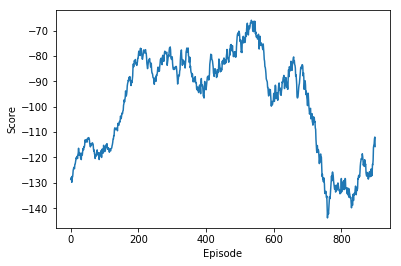

In [39]:
plot_scores(scores)

From the above plot, we see that , rewards are improving , but the reward vs episode curve is not stable

Let's visualize the model

In [40]:
agent.qnetwork_local.load_state_dict(torch.load("dqn_no_target/dqn_agent1000.pkl"))

In [41]:
experience_df=visualize(env,agent)

In [42]:
experience_df[["Gt","Value"]].style.background_gradient(cmap='viridis')

,Gt,Value
0,-409.817,[-70.60997]
1,-401.126,[-70.60997]
2,-396.412,[-70.60997]
3,-387.787,[-70.60997]
4,-379.392,[-70.60997]
5,-371.931,[-70.60997]
6,-365.397,[-70.60997]
7,-358.224,[-70.60997]
8,-351.181,[-70.60997]
9,-344.017,[-70.60997]


### Why so unstable?!

There is a problem in the learning. the [learning](#dqn_learn) section shows, in line 15 and 19. We are getting the target value of the network from the same network! There are two problems with it

- For normal neural network training , the target is fixed. But in this case the target itself is moving!!! Suppose , if we are trying to catch a cow. If the cow is fixed in a position, it is easier to catch it. But if the cow starts moving with our every step, then it is harder !
- Another problem is overestimation! Suppose, if Q network gives a bad future state a good value. As the Q(next_state) is the target, the model will try to learn the weights such that  it gives the future states bad value! So there is a chance of always giving ***bad states*** good values and not learning at all!

#### So the solution? Add target Network!!!

<a id="dqn_with_target"></a>
### DQN with Target Network

***but wait! lets make the learning code a function for future use!***

In [43]:
def train_agent(agent,env,target_folder,eps_start=eps_start,eps_decay=eps_decay,eps_end=eps_end,gamma=gamma,n_episodes=n_episodes,max_t=max_t):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)

            agent.step(state, action, reward, next_state,done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%10==0:
            torch.save(agent.qnetwork_local.state_dict(),"{}/dqn_agent{}.pkl".format(target_folder,i_episode))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    return scores

Let's initialize a target network

In [52]:
agent.qnetwork_target = QNetwork(state_size=state_shape,action_size=action_size,seed=0).to(device)

let's change the ```learn``` method, notice, I am changing only the line ```15``` and I am adding new method ```soft_update``` to update the target network

In [45]:
def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences


    "*** YOUR CODE HERE ***"
    ### My code starts###
    maxQ1=torch.max(self.qnetwork_target(next_states),0)[0]
    maxQ2=torch.max(self.qnetwork_target(next_states),1)[0]
    maxQ=maxQ2.reshape(-1,1)


    y=rewards+gamma*torch.max(maxQ,1)[0]*(1-dones)

    loss=F.mse_loss(y,self.qnetwork_local(states).gather(1,actions))
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [46]:
Agent.learn=learn

In [47]:
Agent.soft_update=soft_update

***so let's start learning again!***

Initializing the agent

In [51]:
agent.__init__(state_size=state_shape,action_size=action_size,seed=0)

In [53]:
scores=train_agent(agent,env,"dqn_with_target")

Episode 100	Average Score: -169.63
Episode 200	Average Score: -143.38
Episode 300	Average Score: -139.81
Episode 400	Average Score: -169.21
Episode 500	Average Score: -149.34
Episode 600	Average Score: -124.22
Episode 700	Average Score: -120.15
Episode 800	Average Score: -68.99
Episode 900	Average Score: -72.74
Episode 1000	Average Score: -107.78


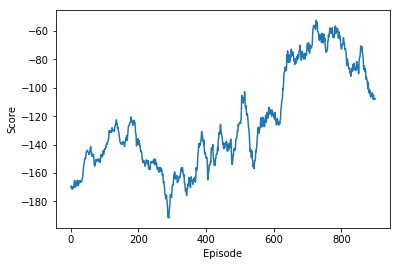

In [54]:
plot_scores(scores)

Above one looks better than the dqn without result. But still unstable

In [55]:
scores_np_dqn_with_target=np.array(scores)
np.savetxt("dqn_with_target/scores.txt",scores_np_dqn_with_target)

Let's plot both scores together

Text(0.5, 1.0, 'DQN')

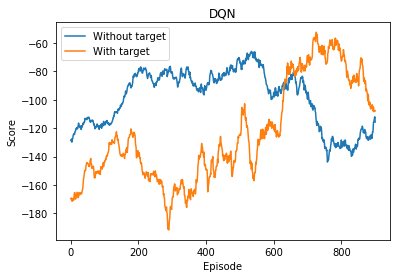

In [59]:
plt.figure()
scores_ma_no_target=moving_average(scores_np,n=100)
scores_ma_with_target=moving_average(scores_np_dqn_with_target,n=100)
plt.plot(np.arange(len(scores_ma_no_target)), scores_ma_no_target,label="Without target")
plt.plot(np.arange(len(scores_ma_with_target)), scores_ma_with_target,label="With target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.title("DQN")


***Stability improved , but not enough!!***

***Let's think again!*** Target network improves the stability slightly. But can we do more?! Obviously! Follow the next article, ***Double Deep Q Network***